In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("./plots/paper.mplstyle")  # Use custom stylesheet
import matplotlib.ticker as mpltick
from matplotlib.colors import LogNorm
import scipy.stats as sps
import pc_analysis as pca

#Some custom colors
yellow = '#fcd024'
orange = '#f2844b'
red = '#bc3587'
blue = '#330498'

#Load the superdarn data from the cnvmap files. Data from this routine is stored in superdarn.h5, so it is left commented here.
#If you wish to reprocess the data for any reason, uncomment.
#superdarn = pca.data_load_routine()

/tmp/ipykernel_435/1005012071.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#Load solar wind data from PRIME
sw_data = pd.read_hdf('data/wind_data_full.h5', 'prime_full') #Load solar wind data from PRIME
sw_data = sw_data.drop_duplicates(subset='Epoch') #Just in case!
#Caluclate Em from solar wind data
sw_data['E_KL'] = pca.EKL(sw_data['Vi_xgse'].to_numpy(), sw_data['Vi_ygse'].to_numpy(), sw_data['Vi_zgse'].to_numpy(), sw_data['B_ygsm'].to_numpy(), sw_data['B_zgsm'].to_numpy()) #Kan-Lee electric field
sw_data['E_KL_sig'] = pca.EKL_err(sw_data['Vi_xgse'].to_numpy(), sw_data['Vi_xgse_sig'].to_numpy(), sw_data['Vi_ygse'].to_numpy(), sw_data['Vi_ygse_sig'].to_numpy(), sw_data['Vi_zgse'].to_numpy(), sw_data['Vi_zgse_sig'].to_numpy(), sw_data['B_ygsm'].to_numpy(), sw_data['B_ygsm_sig'].to_numpy(), sw_data['B_zgsm'].to_numpy(), sw_data['B_zgsm_sig'].to_numpy()) #Kan-Lee electric field
# sw_data['Em_R'] = pca.EMR(sw_data['Vi_xgse'].to_numpy(), sw_data['B_zgsm'].to_numpy()) #Rectified dawn-dusk motional electric field
# sw_data['Em_R_sig'] = pca.EMR_err(sw_data['Vi_xgse'].to_numpy(), sw_data['Vi_xgse_sig'].to_numpy(), sw_data['B_zgsm'].to_numpy(), sw_data['B_zgsm_sig'].to_numpy()) #Error in rectified dawn-dusk motional electric field
sw_data['Em_R'] = pca.EMR(sw_data['Vi_xgse'].to_numpy(), sw_data['B_zgsm'].to_numpy(), by = sw_data['B_ygsm'].to_numpy()) #Rectified dawn-dusk motional electric field
sw_data['Em_R_sig'] = pca.EMR_err(sw_data['Vi_xgse'].to_numpy(), sw_data['Vi_xgse_sig'].to_numpy(), sw_data['B_zgsm'].to_numpy(), sw_data['B_zgsm_sig'].to_numpy(), by = sw_data['B_ygsm'].to_numpy(), by_sig = sw_data['B_ygsm_sig'].to_numpy()) #Error in rectified dawn-dusk motional electric field


#Load outer magnetosheath data from PRIME-SH
sh_data = pd.read_hdf('data/sheath_outputs_cpcp.h5', 'primesh_mid')
sh_data = sh_data.drop_duplicates(subset='Epoch') #Just in case!
sh_data['Erx'] = pca.ERX(sh_data['Ni'].to_numpy(), sh_data['Vi_xgse'].to_numpy(), sh_data['Vi_ygse'].to_numpy(), sh_data['Vi_zgse'].to_numpy(), sh_data['B_xgsm'].to_numpy(), sh_data['B_ygsm'].to_numpy(), sh_data['B_zgsm'].to_numpy(), sh_data['Tiperp'].to_numpy()) #Reconnection electric field
# sh_data['Em_R'] = pca.EMR(sh_data['Vi_xgse'].to_numpy(), sh_data['B_zgsm'].to_numpy()) #Rectified dawn-dusk motional electric field
# sh_data['Em_R_sig'] = pca.EMR_err(sh_data['Vi_xgse'].to_numpy(), sh_data['Vi_xgse_sig'].to_numpy(), sh_data['B_zgsm'].to_numpy(), sh_data['B_zgsm_sig'].to_numpy(),) #Error in rectified dawn-dusk motional electric field
sh_data['Em_R'] = pca.EMR(sh_data['Vi_xgse'].to_numpy(), sh_data['B_zgsm'].to_numpy(), by = sh_data['B_ygsm'].to_numpy()) #Rectified dawn-dusk motional electric field
sh_data['Em_R_sig'] = pca.EMR_err(sh_data['Vi_xgse'].to_numpy(), sh_data['Vi_xgse_sig'].to_numpy(), sh_data['B_zgsm'].to_numpy(), sh_data['B_zgsm_sig'].to_numpy(), by = sh_data['B_ygsm'].to_numpy(), by_sig = sh_data['B_ygsm_sig'].to_numpy()) #Error in rectified dawn-dusk motional electric field
sh_data['E_KL'] = pca.EKL(sh_data['Vi_xgse'].to_numpy(), sh_data['Vi_ygse'].to_numpy(), sh_data['Vi_zgse'].to_numpy(), sh_data['B_ygsm'].to_numpy(), sh_data['B_zgsm'].to_numpy()) #Kan-Lee electric field
sh_data['E_KL_sig'] = pca.EKL_err(sh_data['Vi_xgse'].to_numpy(), sh_data['Vi_xgse_sig'].to_numpy(), sh_data['Vi_ygse'].to_numpy(), sh_data['Vi_ygse_sig'].to_numpy(), sh_data['Vi_zgse'].to_numpy(), sh_data['Vi_zgse_sig'].to_numpy(), sh_data['B_ygsm'].to_numpy(), sh_data['B_ygsm_sig'].to_numpy(), sh_data['B_zgsm'].to_numpy(), sh_data['B_zgsm_sig'].to_numpy()) #Kan-Lee electric field

/mnt/c/Users/conno/Documents/prime-pcp/pc_analysis.py:487: RuntimeWarning: invalid value encountered in sqrt
  erx = 0.02 * 0.2 * (B**2) * (((1+beta)/ni)**(1/2)) * (np.sin(np.arctan2(by, bz)/2))**2 #Reconnection electric field (modified Cassak-Shay)


In [3]:
def closest_argmin(A, B):
    '''
    Helper function that returns indices of elements in array B closest to each element in array A.
    '''
    L = B.size
    sidx_B = B.argsort()
    sorted_B = B[sidx_B]
    sorted_idx = np.searchsorted(sorted_B, A)
    sorted_idx[sorted_idx==L] = L-1
    mask = (sorted_idx > 0) & \
    ((np.abs(A - sorted_B[sorted_idx-1]) < np.abs(A - sorted_B[sorted_idx])) )
    return sidx_B[sorted_idx-mask]

#Load superdarn data
superdarn = pd.read_hdf('data/superdarn.h5', key = 'all_north') #Load superdarn data
#Also, add the shifted data into superdarn dataframe
timeshift = pd.Timedelta(seconds=17*60) #Time shift between bow shock/magnetosheath and ionosphere
# sw_inds = closest_argmin(superdarn['time'].to_numpy(), sw_data['Epoch'].to_numpy()) #Find the indices of sw_data['Epoch'] closest to each superdarn['time']
# sh_inds = closest_argmin(superdarn['time'].to_numpy(), sh_data['Epoch'].to_numpy()) #Find the indices of sh_data['Epoch'] closest to each superdarn['time']
for key in sw_data.columns: #Add the solar wind data into superdarn
    if key == 'Epoch':
        continue
    # #Add the closest elements of sw_data to superdarn data
    # superdarn[key+'_sw'] = sw_data.loc[sw_inds, key].to_numpy()
    #Interpolate the solar wind data to the CPCP times
    superdarn[key+'_sw'] = np.interp(superdarn['time'].astype('int'), (sw_data['Epoch']+timeshift).astype('int'), sw_data[key])
for key in sh_data.columns: #Add sheath data into superdarn
    if key == 'Epoch':
        continue
    # #Add the closest elements of sw_data to superdarn data
    # superdarn[key+'_sh'] = sh_data.loc[sh_inds, key].to_numpy()
    #Interpolate the solar wind data to the CPCP times
    superdarn[key+'_sh'] = np.interp(superdarn['time'].astype('int'), (sh_data['Epoch']+timeshift).astype('int'), sh_data[key])
# superdarn = superdarn.drop_duplicates(subset = sw_data.columns[1:]+'_sw') #Drop duplicate entries due to solar wind data overlap
# superdarn = superdarn.drop_duplicates(subset = sh_data.columns[1:]+'_sh') #Drop duplicate entries due to sheath data overlap

#Drop superdarn times with NaN values in any of the data variables
superdarn = superdarn.dropna(subset='time')

/tmp/ipykernel_362/807292993.py:9: RuntimeWarning: invalid value encountered in divide
  CPCP_binned_sw = CPCP_binned_sw/np.histogram(superdarn['Em_R_sw'][~mask_sw], bins=bins)[0] #Take the average of the bin
/tmp/ipykernel_362/807292993.py:11: RuntimeWarning: invalid value encountered in divide
  CPCP_err_sw = np.sqrt(CPCP_err_sw/np.histogram(superdarn['Em_R_sw'][~mask_sw], bins=bins)[0]-CPCP_binned_sw**2) #Calculate the STD in each bin
/tmp/ipykernel_362/807292993.py:16: RuntimeWarning: invalid value encountered in divide
  CPCP_binned_sh = CPCP_binned_sh/np.histogram(superdarn['Em_R_sh'][~mask_sh], bins=bins)[0]#Take the average of the bin
/tmp/ipykernel_362/807292993.py:18: RuntimeWarning: invalid value encountered in divide
  CPCP_err_sh = np.sqrt(CPCP_err_sh/np.histogram(superdarn['Em_R_sh'][~mask_sh], bins=bins)[0]-CPCP_binned_sh**2) #Calculate the STD in each bin
/tmp/ipykernel_362/807292993.py:26: UserWarning: Log scale: values of z <= 0 have been masked
  cs_sw = ax[0].contou

Text(0.5, 1.0, 'Magnetosheath')

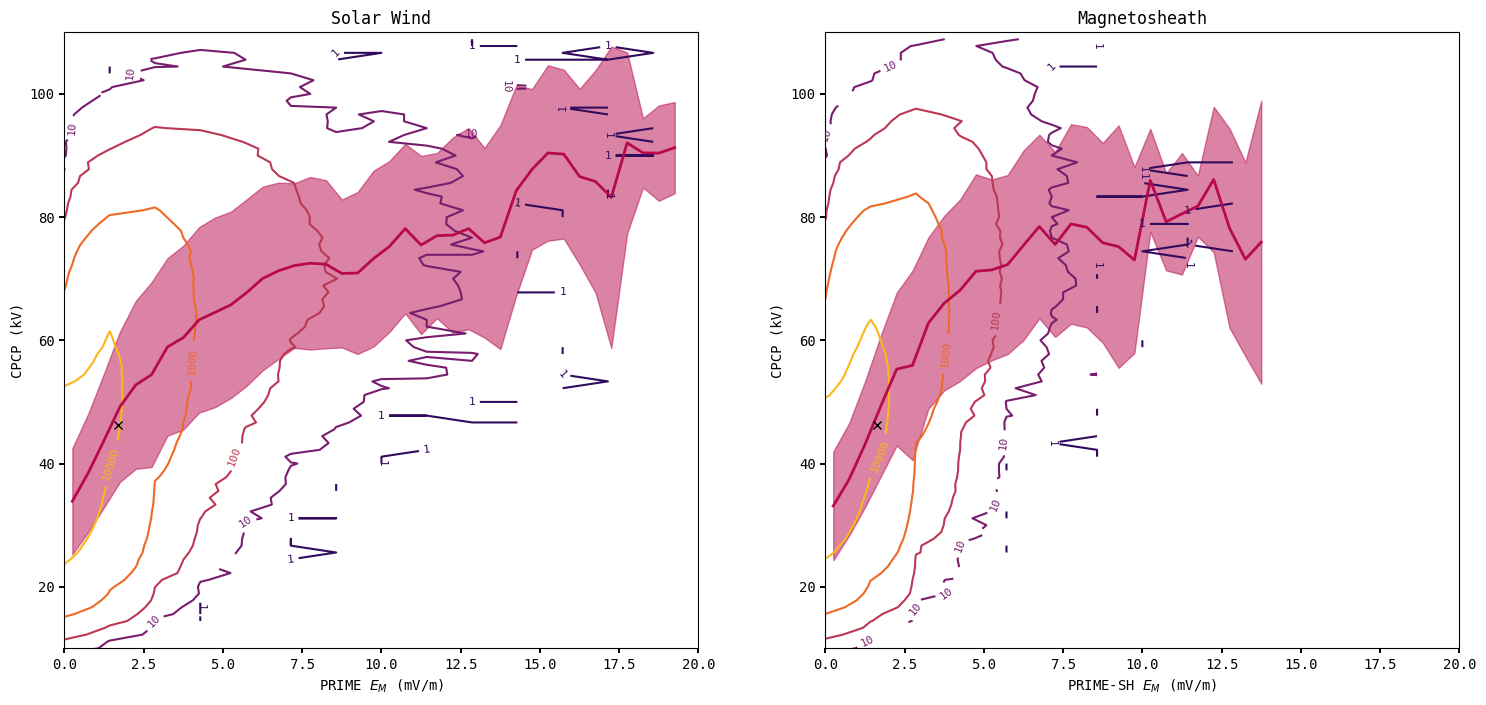

In [4]:
#Bin the CPCP to evaluate the relationship between CPCP and Em_R
xlim = 20 #Maximum Em_R value to include in the plot
ylim = 110 #Maximum CPCP value to include in the plot
binsize = 0.5 #Bin size for regression line, NOT contours
bins = np.arange(0, xlim+binsize, binsize) #Bins for regression line, NOT contours
#Bin the CPCP according to Em_R and average and get std of CPCP in each bin (SOLAR WIND)
mask_sw = np.isnan(superdarn['Em_R_sw']) | np.isnan(superdarn['pot.drop']) | (superdarn['nvec'] < 100) #Mask out bad/missing data
CPCP_binned_sw, _ = np.histogram(superdarn['Em_R_sw'][~mask_sw], bins=bins, weights=superdarn['pot.drop'][~mask_sw]/1000) #Bin the CPCP data wrt Em_R
CPCP_binned_sw = CPCP_binned_sw/np.histogram(superdarn['Em_R_sw'][~mask_sw], bins=bins)[0] #Take the average of the bin
CPCP_err_sw, _ = np.histogram(superdarn['Em_R_sw'][~mask_sw], bins=bins, weights=(superdarn['pot.drop'][~mask_sw]/1000)**2) #Bin the CPCP data variance wrt Em_R
CPCP_err_sw = np.sqrt(CPCP_err_sw/np.histogram(superdarn['Em_R_sw'][~mask_sw], bins=bins)[0]-CPCP_binned_sw**2) #Calculate the STD in each bin
counts_sw, _ = np.histogram(superdarn['Em_R_sw'][~mask_sw], bins=bins) #Calculate the number of samples in each bin
#Bin the CPCP according to Em_R and average and get std of CPCP in each bin (SHEATH)
mask_sh = np.isnan(superdarn['Em_R_sh']) | np.isnan(superdarn['pot.drop']) | (superdarn['nvec'] < 100) #Mask out bad/missing data
CPCP_binned_sh, _ = np.histogram(superdarn['Em_R_sh'][~mask_sh], bins=bins, weights=superdarn['pot.drop'][~mask_sh]/1000) #Bin the CPCP data wrt Em_R
CPCP_binned_sh = CPCP_binned_sh/np.histogram(superdarn['Em_R_sh'][~mask_sh], bins=bins)[0]#Take the average of the bin
CPCP_err_sh, _ = np.histogram(superdarn['Em_R_sh'][~mask_sh], bins=bins, weights=(superdarn['pot.drop'][~mask_sh]/1000)**2) #Bin the CPCP data variance wrt Em_R
CPCP_err_sh = np.sqrt(CPCP_err_sh/np.histogram(superdarn['Em_R_sh'][~mask_sh], bins=bins)[0]-CPCP_binned_sh**2) #Calculate the STD in each bin
counts_sh, _ = np.histogram(superdarn['Em_R_sh'][~mask_sh], bins=bins) #Calculate the number of samples in each bin

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(18,8))
xnbins = 15 #Contour bin number
ynbins = 100 #Contour bin number
#Plot PCC vs Em_R in contours when they are not nan (SOLAR WIND)
hist_sw, _, _ = np.histogram2d(superdarn['pot.drop'][~mask_sw]/1000, superdarn['Em_R_sw'][~mask_sw], bins=[np.linspace(0,ylim,ynbins), np.linspace(0,xlim,xnbins)]) #Make the histogram to base the countours on
cs_sw = ax[0].contour(np.linspace(0,xlim,xnbins)[:-1], np.linspace(0,ylim,ynbins)[:-1], hist_sw, norm=LogNorm(), cmap = 'inferno') #Contour plot all the data
ax[0].clabel(cs_sw, inline=True, fontsize=8) #Label the contours
ax[0].plot(bins[:-1]+binsize/2, CPCP_binned_sw, color='#B7094C', linestyle='-', linewidth=2) #Plot mean CPCP vs Em_R in each regression line bin
ax[0].fill_between(bins[:-1]+binsize/2, CPCP_binned_sw+CPCP_err_sw, CPCP_binned_sw-CPCP_err_sw, color='#B7094C', alpha=0.5) #Fill between mean CPCP+1sigma and mean CPCP-1sigma
ax[0].plot(np.mean(superdarn['Em_R_sw'][~mask_sw]), np.mean(superdarn['pot.drop'][~mask_sw]/1000), color = 'k', marker='x')
ax[0].set_xlim(0,xlim)
ax[0].set_ylim(10,ylim)
ax[0].set_xlabel('PRIME $E_{M}$ (mV/m)')
ax[0].set_ylabel('CPCP (kV)')
ax[0].set_title('Solar Wind')
#Plot PCC vs Em_R in contours when they are not nan (SHEATH)
hist_sh, _, _ = np.histogram2d(superdarn['pot.drop'][~mask_sh]/1000, superdarn['Em_R_sh'][~mask_sh], bins=[np.linspace(0,ylim,ynbins), np.linspace(0,xlim,xnbins)]) #Make the histogram to base the countours on
cs_sh = ax[1].contour(np.linspace(0,xlim,xnbins)[:-1], np.linspace(0,ylim,ynbins)[:-1], hist_sh, norm=LogNorm(), cmap = 'inferno') #Contour plot all the data
ax[1].clabel(cs_sh, inline=True, fontsize=8) #Label the contours
ax[1].plot(bins[:-1]+binsize/2, CPCP_binned_sh, color='#B7094C', linestyle='-', linewidth=2) #Plot mean CPCP vs Em_R in each regression line bin
ax[1].fill_between(bins[:-1]+binsize/2, CPCP_binned_sh+CPCP_err_sh, CPCP_binned_sh-CPCP_err_sh, color='#B7094C', alpha=0.5) #Fill between mean CPCP+1sigma and mean CPCP-1sigma
ax[1].plot(np.mean(superdarn['Em_R_sh'][~mask_sw]), np.mean(superdarn['pot.drop'][~mask_sw]/1000), color = 'k', marker='x')
ax[1].set_xlim(0,xlim)
ax[1].set_ylim(10,ylim)
ax[1].set_xlabel('PRIME-SH $E_{M}$ (mV/m)')
ax[1].set_ylabel('CPCP (kV)')
ax[1].set_title('Magnetosheath')

/tmp/ipykernel_362/2197869059.py:11: UserWarning: Log scale: values of z <= 0 have been masked
  cs = plt.contour(np.arange(0,lim,binsize)[:-1], np.arange(0,lim,binsize)[:-1], hist, norm=LogNorm(), levels=10, cmap = 'inferno')


Text(0.5, 1.0, 'Solar Wind-Magnetosheath $E_{M}$ Joint Distribution')

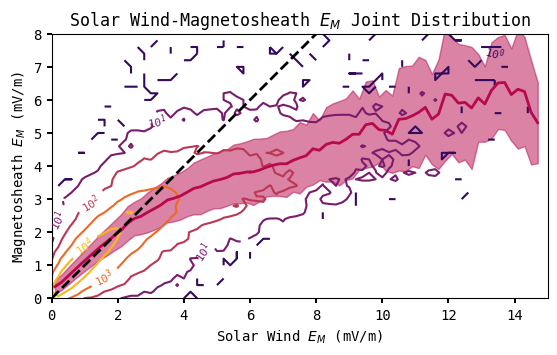

In [5]:
lim = 15 #Maximum SW Em value to include in the plot
binsize = 0.2
bins = np.arange(0, lim+binsize, binsize)
mask = np.isnan(superdarn['Em_R_sw']) | np.isnan(superdarn['Em_R_sh'])
#Bin the sheath Em according to SW Em and average and get std of sheath Em in each bin
Em_mean, _, _ = sps.binned_statistic(superdarn['Em_R_sw'][~mask], superdarn['Em_R_sh'][~mask], statistic = 'mean', bins = np.arange(0,lim,binsize), range = (0,lim))
Em_std, _, _ = sps.binned_statistic(superdarn['Em_R_sw'][~mask], superdarn['Em_R_sh'][~mask], statistic = 'std', bins = np.arange(0,lim,binsize), range = (0,lim))
Em_count, bins, binnum = sps.binned_statistic(superdarn['Em_R_sw'][~mask], superdarn['Em_R_sh'][~mask], statistic = 'count', bins = np.arange(0,lim,binsize), range = (0,lim))

hist, _, _ = np.histogram2d(superdarn['Em_R_sh'][~mask], superdarn['Em_R_sw'][~mask], bins=np.arange(0,lim,binsize))
cs = plt.contour(np.arange(0,lim,binsize)[:-1], np.arange(0,lim,binsize)[:-1], hist, norm=LogNorm(), levels=10, cmap = 'inferno')
plt.plot(bins[:-1]+binsize/2, Em_mean, color='#B7094C', linestyle='-', linewidth=2) #Plot mean
plt.fill_between(bins[:-1]+binsize/2, Em_mean+Em_std, Em_mean-Em_std, color='#B7094C', alpha=0.5) #Fill between mean SH Em+1sigma and mean SH Em-1sigma
plt.plot([0, lim], [0, lim], color='k', linestyle='--', linewidth=2) #Plot y=x line
fmt = mpltick.LogFormatterSciNotation()
fmt.create_dummy_axis()
plt.clabel(cs, inline=True, fontsize=8, fmt=fmt) #Label the contours
plt.xlim(0,lim)
plt.ylim(0,8)
plt.xlabel('Solar Wind $E_{M}$ (mV/m)')
plt.ylabel('Magnetosheath $E_{M}$ (mV/m)')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'Solar Wind-Magnetosheath $E_{M}$ Joint Distribution')
# plt.savefig('./plots/sw_sh_Em_jd.pdf', bbox_inches = 'tight')

In [6]:
regresult_low = sps.linregress(superdarn['Em_R_sw'][(~mask)&(superdarn['Em_R_sw']<1.5)], superdarn['Em_R_sh'][(~mask)&(superdarn['Em_R_sw']<1.5)])
regresult_high = sps.linregress(superdarn['Em_R_sw'][(~mask)&(superdarn['Em_R_sw']>3)], superdarn['Em_R_sh'][(~mask)&(superdarn['Em_R_sw']>3)])
print('Initial slope: '+str(regresult_low.slope)[0:5]+' (r: '+str(regresult_low.rvalue)[0:5]+')')
print('Post-knee slope: '+str(regresult_high.slope)[0:5]+' (r: '+str(regresult_high.rvalue)[0:5]+')')

Initial slope: 0.924 (r: 0.738)
Post-knee slope: 0.339 (r: 0.597)


/tmp/ipykernel_362/506420140.py:15: UserWarning: Log scale: values of z <= 0 have been masked
  cs = plt.contour(np.arange(0,xlim,xbinsize)[:-1], np.arange(0,xlim,xbinsize)[:-1], hist, norm=LogNorm(), levels=10, cmap = 'inferno')


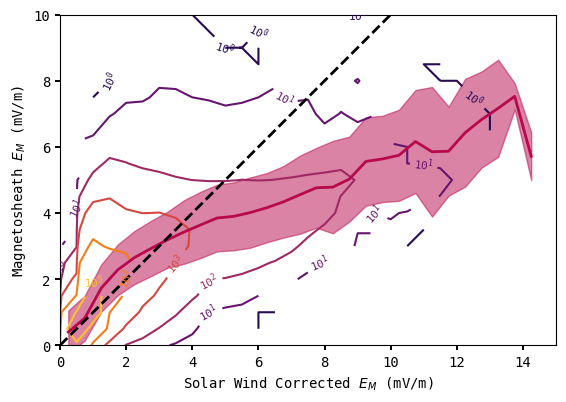

In [7]:
#Correct for the regression attenuation in the solar wind Em, just to see if the above plot is actually valid (it is)
sig2b = np.var(np.log(superdarn['Em_R_sw']), ddof = 1) #Population between-timestep variance
sig2w = np.mean(np.log(superdarn['Em_R_sig_sw'])**2) #Population between-measurement variance
lambda_p = 1 + (np.log(superdarn['Em_R_sig_sw'])**2)/(sig2b) #Regression attenuation correction factor

mask_regrecal = ~( np.isnan(superdarn['Em_R_sw']) | np.isnan(superdarn['Em_R_sig_sw']) | np.isnan(superdarn['Em_R_sh']) | np.isnan(lambda_p) | np.isnan(superdarn['pot.drop']) | (superdarn['nvec'] < 50) )

xlim = 15 #Em_R limit
xbinsize = 0.5 #X binsize (mV/m) for nonlinear regression
Em_corr_mean, _, _ = sps.binned_statistic(np.exp(np.log(superdarn['Em_R_sw'][mask_regrecal])/lambda_p[mask_regrecal]), superdarn['Em_R_sh'][mask_regrecal], statistic = 'mean', bins = np.arange(0,xlim,xbinsize), range = (0,xlim))
Em_corr_std, _, _ = sps.binned_statistic(np.exp(np.log(superdarn['Em_R_sw'][mask_regrecal]/lambda_p[mask_regrecal])), superdarn['Em_R_sh'][mask_regrecal], statistic = 'std', bins = np.arange(0,xlim,xbinsize), range = (0,xlim))
Em_corr_count, bins_corr, binnum_corr = sps.binned_statistic(np.exp(np.log(superdarn['Em_R_sw'][mask_regrecal]/lambda_p[mask_regrecal])), superdarn['Em_R_sh'][mask_regrecal], statistic = 'count', bins = np.arange(0,xlim,xbinsize), range = (0,xlim))

hist, _, _ = np.histogram2d(superdarn['Em_R_sh'][mask_regrecal], np.exp(np.log(superdarn['Em_R_sw'][mask_regrecal])/lambda_p[mask_regrecal]), bins=np.arange(0,xlim,xbinsize))
cs = plt.contour(np.arange(0,xlim,xbinsize)[:-1], np.arange(0,xlim,xbinsize)[:-1], hist, norm=LogNorm(), levels=10, cmap = 'inferno')
plt.plot(bins_corr[:-1]+xbinsize/2, Em_corr_mean, color='#B7094C', linestyle='-', linewidth=2) #Plot mean
plt.fill_between(bins_corr[:-1]+xbinsize/2, Em_corr_mean+Em_corr_std, Em_corr_mean-Em_corr_std, color='#B7094C', alpha=0.5) #Fill between mean SH Em+1sigma and mean SH Em-1sigma
plt.plot([0, xlim], [0, xlim], color='k', linestyle='--', linewidth=2) #Plot y=x line
fmt = mpltick.LogFormatterSciNotation()
fmt.create_dummy_axis()
plt.clabel(cs, inline=True, fontsize=8, fmt=fmt) #Label the contours
plt.xlim(0,xlim)
plt.ylim(0,10)
plt.xlabel('Solar Wind Corrected $E_{M}$ (mV/m)')
plt.ylabel('Magnetosheath $E_{M}$ (mV/m)')
plt.gca().set_aspect('equal', adjustable='box')

/tmp/ipykernel_435/1121099863.py:18: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax[0, 0].contour(np.arange(xrange[0], xrange[1]+binsize, binsize)[:-1], np.arange(yrange[0], yrange[1]+binsize, binsize)[:-1], hist, norm=LogNorm(), levels=10, cmap = 'inferno')
/tmp/ipykernel_435/1121099863.py:43: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax[0, 1].contour(np.arange(xrange[0], xrange[1]+binsize, binsize)[:-1], np.arange(yrange[0], yrange[1]+binsize, binsize)[:-1], hist, norm=LogNorm(), levels=10, cmap = 'inferno')
/tmp/ipykernel_435/1121099863.py:73: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax[1, 0].contour(np.arange(xrange[0], xrange[1]+binsize, binsize)[:-1], np.arange(yrange[0], yrange[1]+binsize, binsize)[:-1], hist, norm=LogNorm(), levels=10, cmap = 'inferno')
/tmp/ipykernel_435/1121099863.py:104: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax[1, 1].contour(np.arange(xrange[0], xrange[1]+binsize, 

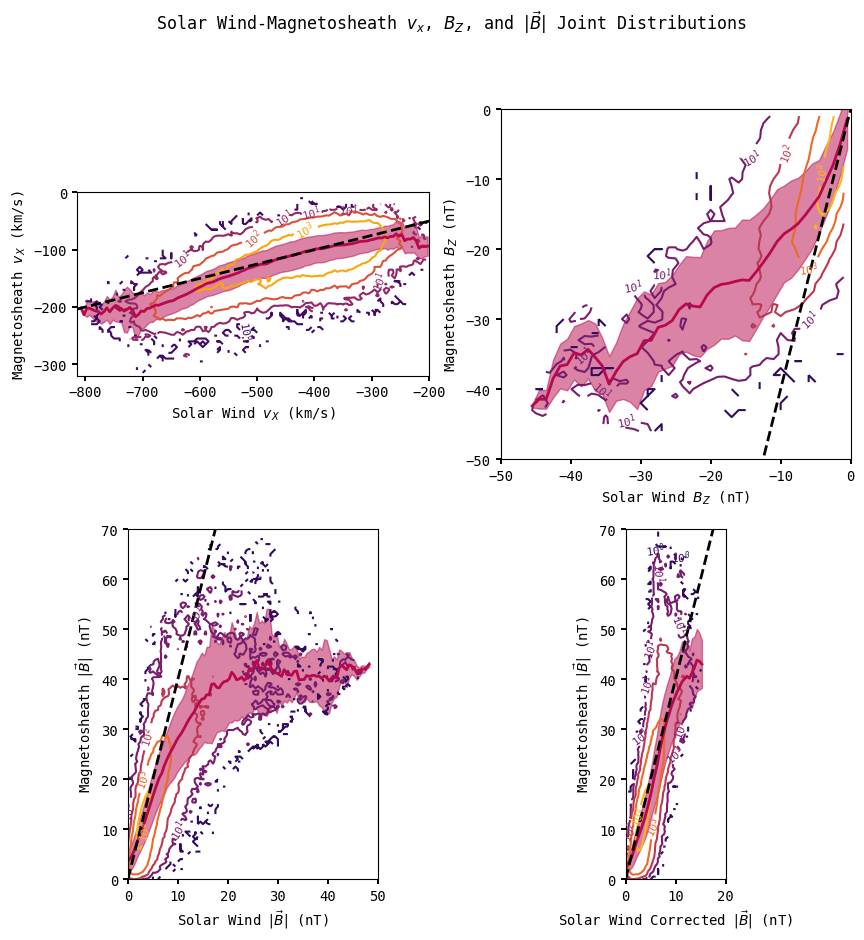

In [5]:
#Joint distributions of SW and SH Vx and Bz values

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))
fig.suptitle(r'Solar Wind-Magnetosheath $v_{x}$, $B_{Z}$, and $|\vec{B}|$ Joint Distributions')
Ma = 0.0458 * np.abs(np.sqrt(superdarn['Vi_xgse_sw']**2 + superdarn['Vi_ygse_sw']**2 + superdarn['Vi_zgse_sw']**2)) * np.sqrt(superdarn['Ne_sw']) / np.sqrt(superdarn['B_xgsm_sw']**2 + superdarn['B_ygsm_sw']**2 + superdarn['B_zgsm_sw']**2)

xrange = np.asarray([-815, -200]) #Range of SW Vx values to include in the plot
yrange = np.asarray([-320, 0]) #Range of SH Vx values to include in the plot
binsize = 5
bins = np.arange(xrange[0], xrange[1]+binsize, binsize)
mask = np.isnan(superdarn['Vi_xgse_sw']) | np.isnan(superdarn['Vi_xgse_sh'])# | (Ma < 11)
#Bin the sheath Vx according to SW Vx and average and get std of sheath Vx in each bin
Vx_mean, _, _ = sps.binned_statistic(superdarn['Vi_xgse_sw'][~mask], superdarn['Vi_xgse_sh'][~mask], statistic = 'mean', bins = np.arange(xrange[0], xrange[1]+binsize, binsize), range = (xrange[0], xrange[1]))
Vx_std, _, _ = sps.binned_statistic(superdarn['Vi_xgse_sw'][~mask], superdarn['Vi_xgse_sh'][~mask], statistic = 'std', bins = np.arange(xrange[0], xrange[1]+binsize, binsize), range = (xrange[0], xrange[1]))
Vx_count, bins, binnum = sps.binned_statistic(superdarn['Vi_xgse_sw'][~mask], superdarn['Vi_xgse_sh'][~mask], statistic = 'count', bins = np.arange(xrange[0], xrange[1]+binsize, binsize), range = (xrange[0], xrange[1]))

hist, _, _ = np.histogram2d(superdarn['Vi_xgse_sh'][~mask], superdarn['Vi_xgse_sw'][~mask], bins=[np.arange(yrange[0], yrange[1]+binsize, binsize), np.arange(xrange[0], xrange[1]+binsize, binsize)])
cs = ax[0, 0].contour(np.arange(xrange[0], xrange[1]+binsize, binsize)[:-1], np.arange(yrange[0], yrange[1]+binsize, binsize)[:-1], hist, norm=LogNorm(), levels=10, cmap = 'inferno')
ax[0, 0].plot(bins[:-1]+binsize/2, Vx_mean, color='#B7094C', linestyle='-', linewidth=2) #Plot mean
ax[0, 0].fill_between(bins[:-1]+binsize/2, Vx_mean+Vx_std, Vx_mean-Vx_std, color='#B7094C', alpha=0.5) #Fill between mean SH Vx+1sigma and mean SH Vx-1sigma
ax[0, 0].plot(xrange, 0.25*xrange, color='k', linestyle='--', linewidth=2) #Plot y=0.25x line
fmt = mpltick.LogFormatterSciNotation()
fmt.create_dummy_axis()
ax[0, 0].clabel(cs, inline=True, fontsize=8, fmt=fmt) #Label the contours
ax[0, 0].set_xlim(xrange[0],xrange[1])
ax[0, 0].set_ylim(yrange[0],yrange[1])
ax[0, 0].set_xlabel(r'Solar Wind $v_{X}$ (km/s)')
ax[0, 0].set_ylabel(r'Magnetosheath $v_{X}$ (km/s)')
ax[0, 0].set_aspect('equal', adjustable='box')


xrange = np.asarray([-50,0]) #Range of SW Bz values to include in the plot
yrange = np.asarray([-50,0]) #Range of SH Bz values to include in the plot
binsize = 1
bins = np.arange(xrange[0], xrange[1]+binsize, binsize)
mask = np.isnan(superdarn['B_zgsm_sw']) | np.isnan(superdarn['B_zgsm_sh'])# | (Ma < 11)
#Bin the sheath Bz according to SW Bz and average and get std of sheath Bz in each bin
Bz_mean, _, _ = sps.binned_statistic(superdarn['B_zgsm_sw'][~mask], superdarn['B_zgsm_sh'][~mask], statistic = 'mean', bins = np.arange(xrange[0], xrange[1]+binsize, binsize), range = (xrange[0], xrange[1]))
Bz_std, _, _ = sps.binned_statistic(superdarn['B_zgsm_sw'][~mask], superdarn['B_zgsm_sh'][~mask], statistic = 'std', bins = np.arange(xrange[0], xrange[1]+binsize, binsize), range = (xrange[0], xrange[1]))
Bz_count, bins, binnum = sps.binned_statistic(superdarn['B_zgsm_sw'][~mask], superdarn['B_zgsm_sh'][~mask], statistic = 'count', bins = np.arange(xrange[0], xrange[1]+binsize, binsize), range = (xrange[0], xrange[1]))

hist, _, _ = np.histogram2d(superdarn['B_zgsm_sh'][~mask], superdarn['B_zgsm_sw'][~mask], bins=[np.arange(yrange[0], yrange[1]+binsize, binsize), np.arange(xrange[0], xrange[1]+binsize, binsize)])
cs = ax[0, 1].contour(np.arange(xrange[0], xrange[1]+binsize, binsize)[:-1], np.arange(yrange[0], yrange[1]+binsize, binsize)[:-1], hist, norm=LogNorm(), levels=10, cmap = 'inferno')
ax[0, 1].plot(bins[:-1]+binsize/2, Bz_mean, color='#B7094C', linestyle='-', linewidth=2) #Plot mean
ax[0, 1].fill_between(bins[:-1]+binsize/2, Bz_mean+Bz_std, Bz_mean-Bz_std, color='#B7094C', alpha=0.5) #Fill between mean SH Bz+1sigma and mean SH Bz-1sigma
ax[0, 1].plot(xrange, 4*xrange, color='k', linestyle='--', linewidth=2) #Plot y=4x line
fmt = mpltick.LogFormatterSciNotation()
fmt.create_dummy_axis()
ax[0, 1].clabel(cs, inline=True, fontsize=8, fmt=fmt) #Label the contours
ax[0, 1].set_xlim(xrange[0],xrange[1])
ax[0, 1].set_ylim(yrange[0],yrange[1])
ax[0, 1].set_xlabel(r'Solar Wind $B_{Z}$ (nT)')
ax[0, 1].set_ylabel(r'Magnetosheath $B_{Z}$ (nT)')
ax[0, 1].set_aspect('equal', adjustable='box')



B_sw = np.sqrt(superdarn['B_xgsm_sw']**2 +superdarn['B_ygsm_sw']**2 + superdarn['B_zgsm_sw']**2)
B_sw_sig = np.sqrt((superdarn['B_xgsm_sw']**2) * (superdarn['B_xgsm_sig_sw']**2)/(superdarn['B_xgsm_sw']**2 +superdarn['B_ygsm_sw']**2 + superdarn['B_zgsm_sw']**2) +
                   (superdarn['B_ygsm_sw']**2) * (superdarn['B_ygsm_sig_sw']**2)/(superdarn['B_xgsm_sw']**2 +superdarn['B_ygsm_sw']**2 + superdarn['B_zgsm_sw']**2) +
                   (superdarn['B_zgsm_sw']**2) * (superdarn['B_zgsm_sig_sw']**2)/(superdarn['B_xgsm_sw']**2 +superdarn['B_ygsm_sw']**2 + superdarn['B_zgsm_sw']**2))
B_sh = np.sqrt(superdarn['B_xgsm_sh']**2 +superdarn['B_ygsm_sh']**2 + superdarn['B_zgsm_sh']**2)
mask= ~( np.isnan(B_sw) | np.isnan(B_sh))

xrange = np.asarray([0,50]) #Range of SW B values to include in the plot
yrange = np.asarray([0,70]) #Range of SH B values to include in the plot
binsize = 0.5
B_mean, _, _ = sps.binned_statistic(B_sw[mask], B_sh[mask], statistic = 'mean', bins = np.arange(xrange[0], xrange[1]+binsize, binsize), range = (xrange[0], xrange[1]))
B_std, _, _ = sps.binned_statistic(B_sw[mask], B_sh[mask], statistic = 'std', bins = np.arange(xrange[0], xrange[1]+binsize, binsize), range = (xrange[0], xrange[1]))
B_count, bins, binnum = sps.binned_statistic(B_sw[mask], B_sh[mask], statistic = 'count', bins = np.arange(xrange[0], xrange[1]+binsize, binsize), range = (xrange[0], xrange[1]))

hist, _, _ = np.histogram2d(B_sh[mask], B_sw[mask], bins=[np.arange(yrange[0], yrange[1]+binsize, binsize), np.arange(xrange[0], xrange[1]+binsize, binsize)])
cs = ax[1, 0].contour(np.arange(xrange[0], xrange[1]+binsize, binsize)[:-1], np.arange(yrange[0], yrange[1]+binsize, binsize)[:-1], hist, norm=LogNorm(), levels=10, cmap = 'inferno')
ax[1, 0].plot(bins[:-1]+binsize/2, B_mean, color='#B7094C', linestyle='-', linewidth=2) #Plot mean
ax[1, 0].fill_between(bins[:-1]+binsize/2, B_mean+B_std, B_mean-B_std, color='#B7094C', alpha=0.5) #Fill between mean SH B+1sigma and mean SH B-1sigma
ax[1, 0].plot(xrange, 4*xrange, color='k', linestyle='--', linewidth=2) #Plot y=4x line
fmt = mpltick.LogFormatterSciNotation()
fmt.create_dummy_axis()
ax[1, 0].clabel(cs, inline=True, fontsize=8, fmt=fmt) #Label the contours
ax[1, 0].set_xlim(xrange[0],xrange[1])
ax[1, 0].set_ylim(yrange[0],yrange[1])
ax[1, 0].set_xlabel(r'Solar Wind $|\vec{B}|$ (nT)')
ax[1, 0].set_ylabel(r'Magnetosheath $|\vec{B}|$ (nT)')
ax[1, 0].set_aspect('equal', adjustable='box')

#Correct for the regression attenuation in the solar wind B
sig2b_sw = np.var(B_sw, ddof = 1) #Population between-timestep variance
sig2w_sw = np.mean(B_sw_sig**2) #Population between-measurement variance
lambda_p_sw = (sig2b_sw)/(sig2b_sw + B_sw_sig**2) #Regression attenuation correction factor
lambda_blp_sw = sig2b_sw/(B_sw_sig**2)
B_corr_sw = (1-lambda_p_sw)*np.mean(B_sw) + lambda_p_sw*B_sw

xrange = np.asarray([0,20]) #Range of corrected SW B values to include in the plot
yrange = np.asarray([0,70]) #Range of SH B values to include in the plot
binsize = 0.5
bins = np.arange(xrange[0], xrange[1]+binsize, binsize)
mask = np.isnan(B_corr_sw) | np.isnan(B_sw_sig) | np.isnan(lambda_p_sw)# | (Ma < 11)
#Bin the sheath B according to corrected SW B and average and get std of sheath B in each bin
B_corr_mean, _, _ = sps.binned_statistic(B_corr_sw[~mask], B_sh[~mask], statistic = 'mean', bins = np.arange(xrange[0], xrange[1]+binsize, binsize), range = (xrange[0], xrange[1]))
B_corr_std, _, _ = sps.binned_statistic(B_corr_sw[~mask], B_sh[~mask], statistic = 'std', bins = np.arange(xrange[0], xrange[1]+binsize, binsize), range = (xrange[0], xrange[1]))
B_corr_count, bins, binnum = sps.binned_statistic(B_corr_sw[~mask], B_sh[~mask], statistic = 'count', bins = np.arange(xrange[0], xrange[1]+binsize, binsize), range = (xrange[0], xrange[1]))

hist, _, _ = np.histogram2d(B_sh[~mask], B_corr_sw[~mask], bins=[np.arange(yrange[0], yrange[1]+binsize, binsize), np.arange(xrange[0], xrange[1]+binsize, binsize)])
cs = ax[1, 1].contour(np.arange(xrange[0], xrange[1]+binsize, binsize)[:-1], np.arange(yrange[0], yrange[1]+binsize, binsize)[:-1], hist, norm=LogNorm(), levels=10, cmap = 'inferno')
ax[1, 1].plot(bins[:-1]+binsize/2, B_corr_mean, color='#B7094C', linestyle='-', linewidth=2) #Plot mean
ax[1, 1].fill_between(bins[:-1]+binsize/2, B_corr_mean+B_corr_std, B_corr_mean-B_corr_std, color='#B7094C', alpha=0.5) #Fill between mean SH B+1sigma and mean SH B-1sigma
ax[1, 1].plot(xrange, 4*xrange, color='k', linestyle='--', linewidth=2) #Plot y=4x line
fmt = mpltick.LogFormatterSciNotation()
fmt.create_dummy_axis()
ax[1, 1].clabel(cs, inline=True, fontsize=8, fmt=fmt) #Label the contours
ax[1, 1].set_xlim(xrange[0],xrange[1])
ax[1, 1].set_ylim(yrange[0],yrange[1])
ax[1, 1].set_xlabel(r'Solar Wind Corrected $|\vec{B}|$ (nT)')
ax[1, 1].set_ylabel(r'Magnetosheath $|\vec{B}|$ (nT)')
ax[1, 1].set_aspect('equal', adjustable='box')
# plt.savefig('./plots/sw_sh_VxBzB_jd.pdf', bbox_inches = 'tight')

/home/connor/.cache/pypoetry/virtualenvs/prime-pcp-R9PMZO5N-py3.9/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_362/3109486345.py:17: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax[0].contour(np.arange(0,lim,binsize)[:-1], np.arange(0,lim,binsize)[:-1], hist, norm=LogNorm(), levels=10, cmap = 'inferno')
/tmp/ipykernel_362/3109486345.py:42: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax[1].contour(np.arange(0,lim,binsize)[:-1], np.arange(0,lim,binsize)[:-1], hist, norm=LogNorm(), levels=10, cmap = 'inferno')


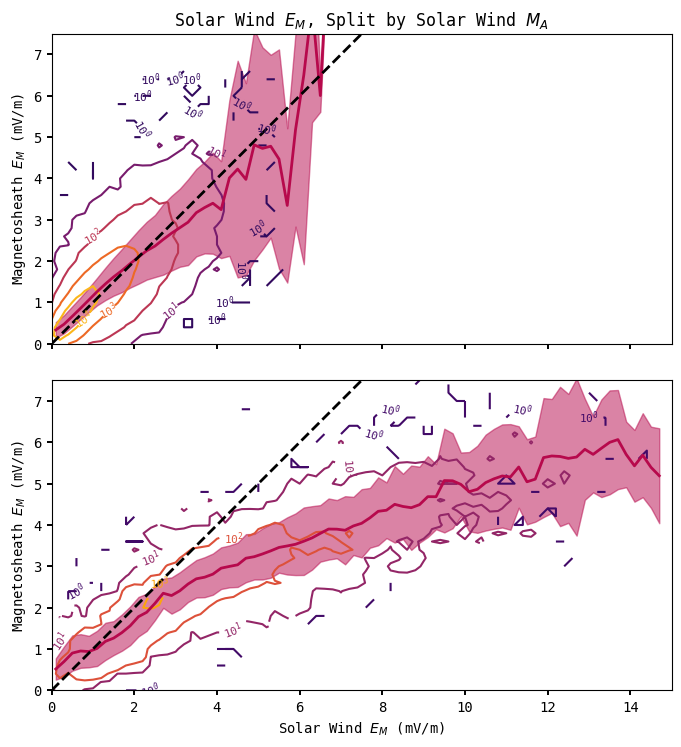

In [11]:
#Split the EM joint distribution by mach number

fig, ax = plt.subplots(nrows=2, ncols = 1, figsize = (8,9), sharex=True)
plt.subplots_adjust(hspace = 0)

lim = 7 #Maximum SW Em value to include in the plot
binsize = 0.2
bins = np.arange(0, lim+binsize, binsize)
Ma = 0.0458 * np.abs(np.sqrt(superdarn['Vi_xgse_sw']**2 + superdarn['Vi_ygse_sw']**2 + superdarn['Vi_zgse_sw']**2)) * np.sqrt(superdarn['Ne_sw']) / np.sqrt(superdarn['B_xgsm_sw']**2 + superdarn['B_ygsm_sw']**2 + superdarn['B_zgsm_sw']**2)
mask = (~(np.isnan(superdarn['Em_R_sw']) | np.isnan(superdarn['Em_R_sh']))) & (Ma >11)
#Bin the sheath Em according to SW Em and average and get std of sheath Em in each bin
Em_mean, _, _ = sps.binned_statistic(superdarn['Em_R_sw'][mask], superdarn['Em_R_sh'][mask], statistic = 'mean', bins = np.arange(0,lim,binsize), range = (0,lim))
Em_std, _, _ = sps.binned_statistic(superdarn['Em_R_sw'][mask], superdarn['Em_R_sh'][mask], statistic = 'std', bins = np.arange(0,lim,binsize), range = (0,lim))
Em_count, bins, binnum = sps.binned_statistic(superdarn['Em_R_sw'][mask], superdarn['Em_R_sh'][mask], statistic = 'count', bins = np.arange(0,lim,binsize), range = (0,lim))

hist, _, _ = np.histogram2d(superdarn['Em_R_sh'][mask], superdarn['Em_R_sw'][mask], bins=np.arange(0,lim,binsize))
cs = ax[0].contour(np.arange(0,lim,binsize)[:-1], np.arange(0,lim,binsize)[:-1], hist, norm=LogNorm(), levels=10, cmap = 'inferno')
ax[0].plot(bins[:-1]+binsize/2, Em_mean, color='#B7094C', linestyle='-', linewidth=2) #Plot mean
ax[0].fill_between(bins[:-1]+binsize/2, Em_mean+Em_std, Em_mean-Em_std, color='#B7094C', alpha=0.5) #Fill between mean SH Em+1sigma and mean SH Em-1sigma
ax[0].plot([0, lim*2], [0, lim*2], color='k', linestyle='--', linewidth=2) #Plot y=x line
fmt = mpltick.LogFormatterSciNotation()
fmt.create_dummy_axis()
ax[0].clabel(cs, inline=True, fontsize=8, fmt=fmt) #Label the contours
# ax[0].set_xlim(0,lim)
ax[0].set_ylim(0,7.5)
# ax[0].set_xticklabels([])
ax[0].set_ylabel('Magnetosheath $E_{M}$ (mV/m)')
ax[0].set_aspect('equal', adjustable='box')
ax[0].set_title('Solar Wind $E_{M}$, Split by Solar Wind $M_{A}$')

lim = 15 #Maximum SW Em value to include in the plot
binsize = 0.2
bins = np.arange(0, lim+binsize, binsize)
Ma = 0.0458 * np.abs(np.sqrt(superdarn['Vi_xgse_sw']**2 + superdarn['Vi_ygse_sw']**2 + superdarn['Vi_zgse_sw']**2)) * np.sqrt(superdarn['Ne_sw']) / np.sqrt(superdarn['B_xgsm_sw']**2 + superdarn['B_ygsm_sw']**2 + superdarn['B_zgsm_sw']**2)
mask = (~(np.isnan(superdarn['Em_R_sw']) | np.isnan(superdarn['Em_R_sh']))) & (Ma < 5)
#Bin the sheath Em according to SW Em and average and get std of sheath Em in each bin
Em_mean, _, _ = sps.binned_statistic(superdarn['Em_R_sw'][mask], superdarn['Em_R_sh'][mask], statistic = 'mean', bins = np.arange(0,lim,binsize), range = (0,lim))
Em_std, _, _ = sps.binned_statistic(superdarn['Em_R_sw'][mask], superdarn['Em_R_sh'][mask], statistic = 'std', bins = np.arange(0,lim,binsize), range = (0,lim))
Em_count, bins, binnum = sps.binned_statistic(superdarn['Em_R_sw'][mask], superdarn['Em_R_sh'][mask], statistic = 'count', bins = np.arange(0,lim,binsize), range = (0,lim))

hist, _, _ = np.histogram2d(superdarn['Em_R_sh'][mask], superdarn['Em_R_sw'][mask], bins=np.arange(0,lim,binsize))
cs = ax[1].contour(np.arange(0,lim,binsize)[:-1], np.arange(0,lim,binsize)[:-1], hist, norm=LogNorm(), levels=10, cmap = 'inferno')
ax[1].plot(bins[:-1]+binsize/2, Em_mean, color='#B7094C', linestyle='-', linewidth=2) #Plot mean
ax[1].fill_between(bins[:-1]+binsize/2, Em_mean+Em_std, Em_mean-Em_std, color='#B7094C', alpha=0.5) #Fill between mean SH Em+1sigma and mean SH Em-1sigma
ax[1].plot([0, lim], [0, lim], color='k', linestyle='--', linewidth=2) #Plot y=x line
fmt = mpltick.LogFormatterSciNotation()
fmt.create_dummy_axis()
ax[1].clabel(cs, inline=True, fontsize=8, fmt=fmt) #Label the contours
ax[1].set_xlim(0,lim)
ax[1].set_ylim(0,7.5)
ax[1].set_xlabel('Solar Wind $E_{M}$ (mV/m)')
ax[1].set_ylabel('Magnetosheath $E_{M}$ (mV/m)')
ax[1].set_aspect('equal', adjustable='box')
#plt.savefig('./plots/sw_sh_Em_jd_MA.pdf', bbox_inches = 'tight')

In [11]:
len(sw_data[(sw_data['Epoch'] > pd.to_datetime('20130101 00:00:00+0000')) & (sw_data['Epoch'] < pd.to_datetime('20230101 00:00:00+0000')) & (sw_data['interp_frac'] > 0.15)])*100/60/60/24

408.5787037037037

In [12]:
len(sh_data[(sh_data['Epoch'] > pd.to_datetime('20130101 00:00:00+0000')) & (sh_data['Epoch'] < pd.to_datetime('20230101 00:00:00+0000')) & (sh_data['interp_frac'] > 0.05)])*100/60/60/24

1292.0891203703702

In [ ]:
#Load outer magnetosheath data from PRIME-SH
sh_data_out = pd.read_hdf('data/sheath_outputs_cpcp.h5', 'primesh_bs')
sh_data_out = sh_data_out.drop_duplicates(subset='Epoch')

#Load middle magnetosheath data from PRIME-SH
sh_data_mid = pd.read_hdf('data/sheath_outputs_cpcp.h5', 'primesh_mid')
sh_data_mid = sh_data_mid.drop_duplicates(subset='Epoch')

#Load inner magnetosheath data from PRIME-SH
sh_data_in = pd.read_hdf('data/sheath_outputs_cpcp.h5', 'primesh_mp')
sh_data_in = sh_data_in.drop_duplicates(subset='Epoch')

(array([1.400780e+05, 3.385760e+05, 9.702510e+05, 2.387137e+06,
        4.509043e+06, 4.104790e+05, 2.860000e+02, 2.010000e+02,
        2.590000e+02, 3.450000e+02]),
 array([-100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.,   40.,   60.,
          80.,  100.]),
 <BarContainer object of 10 artists>)

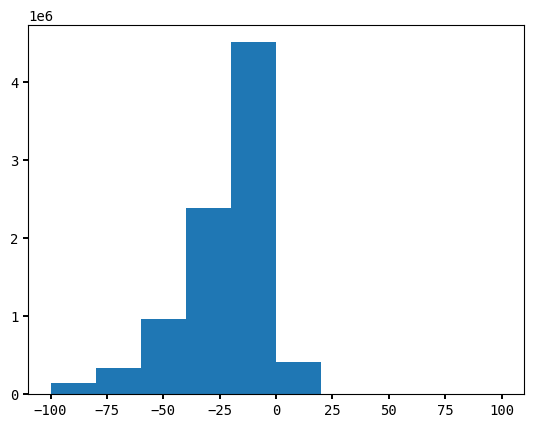

In [37]:
x_out = 13.25 #X Position of outer sheath dataset
x_mid = 12.25 #X Position of middle sheath dataset
x_in = 11.25 #X Position of inner sheath dataset
mp_oi = 11.25 + (0 - sh_data_in['Vi_xgse'])*(x_out - x_in)/(sh_data_out['Vi_xgse'] - sh_data_in['Vi_xgse']) #13.25 - sh_data_out['Vi_xgse'] * (11.25 - 13.25) / (sh_data_in['Vi_xgse'] - sh_data_out['Vi_xgse']) #Magnetopause determined by outer-inner linear relationship
mp_om = 12.25 + (0 - sh_data_mid['Vi_xgse'])*(x_out - x_mid)/(sh_data_out['Vi_xgse'] - sh_data_mid['Vi_xgse']) #Magnetopause determined by outer-middle linear relationship
mp_mi = 11.25 + (0 - sh_data_in['Vi_xgse'])*(x_mid - x_in)/(sh_data_mid['Vi_xgse'] - sh_data_in['Vi_xgse']) #Magnetopause determined by outer-middle linear relationship
mp_av = np.mean(np.array([mp_oi, mp_om, mp_mi]), axis = 0)
mp_std = np.std(np.array([mp_oi, mp_om, mp_mi]), axis = 0)

plt.hist(mp_mi, range=(-100,100))

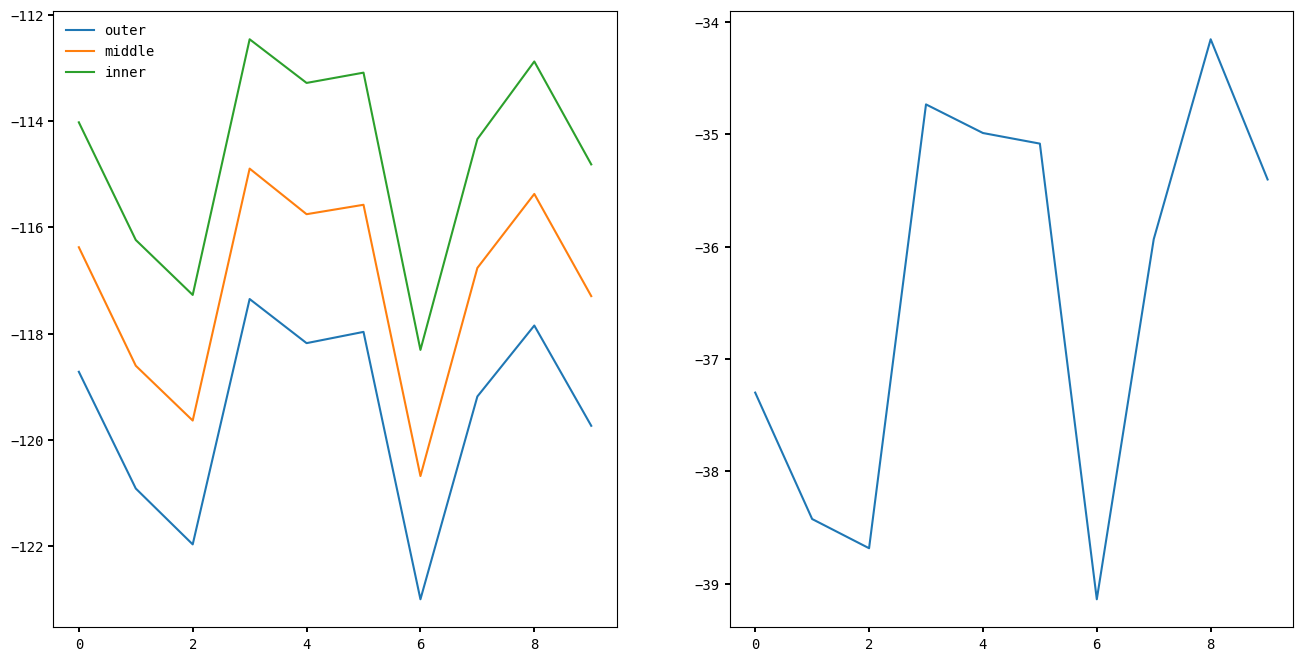

In [38]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,8))
ax[0].plot(sh_data_out['Vi_xgse'][:10], label = 'outer')
ax[0].plot(sh_data_mid['Vi_xgse'][:10], label = 'middle')
ax[0].plot(sh_data_in['Vi_xgse'][:10], label = 'inner')
ax[0].legend()

ax[1].plot(mp_oi[:10])